# Projet Inpainting


Binome:




    -Steban FERNANDEZ
    -Celia KHERFALLAH  
    
Encadrant: 

    -Sylvain LAMPRIER

In [89]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm, trange
from random import shuffle

import tools
import importlib
import matplotlib.patches as patches
importlib.reload(tools)

from tools import filter_classes, read_img
from matplotlib import gridspec
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb
from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso

import warnings
warnings.filterwarnings("ignore")

In [90]:
x_train, y_train = tools.load_usps("USPS/USPS_train.txt")
x_test,  y_test  = tools.load_usps("USPS/USPS_test.txt")

mu = x_train.mean()
sigma  = x_train.std()

#normalize data
x_train = (x_train - mu) / sigma
x_test  = (x_test  - mu) / sigma

In [91]:
class LinearClassifier:
    def __init__(self, penalty=None, alpha=1., use_tqdm=False):
        """La classe LinearClassifier permet de pouvoir choisir plus simplement
        si l'on souhaite utiliser un classifieur linéaire, RIDGE ou LASSO 
        ainsi que de les paramêtrer facilement.
        
        En entrée:
        penalty: (str / None)
            None pour reg. lin. sans regularisation, 'l1' pour LASSO, 'l2' pour RIDGE
        alpha: (float) 
            cf. param alpha des classes LASSO & RIDGE de sklearn
        use_tqdm: (bool) 
            Affiche ou non une barre de progression
        
        En sortie:
         instance de la classe LinearClassifier
        """
        self.penalty = penalty
        self.alpha = alpha
        self.use_tqdm = use_tqdm
        self.clf_class = LinearRegression if not penalty else (Ridge if penalty == 'l2' else Lasso)
    
    def fit(self, x_train, y_train):
        """Entraine le classifieur.
        
        (np.array)*(np.array) =>(None)
        
        x_train: liste des exemples
        y_train: liste des labels associés
        """
        # Un classifieur pas classe
        self.clfs_names = sorted(set(y_train)) 
        self.clfs = {
            name: self.clf_class(
                **{'alpha': self.alpha}
                if not self.clf_class == LinearRegression 
                else {}) 
            for name in self.clfs_names
        }
        #Constuire les datasets pour chaque classifieur, de sorte a ce que la classe 
        #positif represente le classe du classieur et la classe negatif contiennent tous les autres ( oneVsAll)
        #Puis on procede au fit
        for select_class in (tqdm(self.clfs_names) if self.use_tqdm else self.clfs_names):
            
            all_classes = self.clfs_names[:]
            all_other_classes = all_classes[:]
            all_other_classes.remove(select_class)
            #filtrer les classes + balancage
            x, y = filter_classes(x_train, y_train, [select_class], all_other_classes)
            y = np.array(y) * 2 - 1 #class -1, +1
            data_x_y = list(zip(x, y))
            shuffle(data_x_y)
            x, y = zip(*data_x_y)
            x, y = np.array(x), np.array(y)
            #fit 
            self.clfs[select_class].fit(x, y)
            
    def plot_coefs(self, shape):
        """Affiche les coefficients de chaque chiffre sous forme d'une image.
        4 images par ligne.
        (tuple) => (None)
        shape: taille du rectangle de l'image a afficher
        les coefficients doivent être au nombre de shape[0] * shape[1] 
        """
        
        fig = plt.figure(figsize=shape)
        gs = gridspec.GridSpec(4 + 1, len(self.clfs_names) // 4 + 2) 
        
        for i, c in enumerate(self.clfs_names):
            ax = fig.add_subplot(gs[i // 4, i % 4])
            ax.axis('off')
            ax.set_title(str(c), color='red')
            ax.imshow(self.clfs[c].coef_.reshape(shape), cmap='gray')
        gs.update(wspace=.1, hspace=.2)
        fig = plt.gcf()
        fig.show()
        return fig
        
        
    
    def predict(self, x_test):
        """Predit la classe des donnees de x_test.
        (np.array (2D)) => (list)
        
        En entrée:
        x_test: donnees a classifier
        En sortie:
        liste des labels predits associes a chaque element de x_test
        """
        return np.array([
            self.clfs_names[cc] 
            for cc in \
            (np.array([self.clfs[c].predict(x_test) for c in self.clfs_names]) > 0).argmax(0)
        ])
    
    def score(self, x_test, y_test):
        """Permet d'evaluer le classifieur a l'aide de la metrique f1.
        (np.array (2D))*(np.array (1D)) => (float)
        En entrée:
        
        x_test: exemples a predire
        y_test: labels des exemples a predire
        
        En sortie: 
        Le score du classifier
        
        """
        return f1_score(y_test, self.predict(x_test), average=None).mean()

In [92]:
# le choix aléatoire des dictionnaires nous donne des scores differents a chaque execution, c'est pour cela qu'on se propose
# de moyenner le score pour 100 executions 

def get_clf_score(penalty, alpha, x_train, y_train, x_test, y_test, nb_runs=100):
    scores = []
    for _ in trange(nb_runs):
        clf = LinearClassifier(penalty=penalty, alpha=alpha, use_tqdm=False)
        clf.fit(x_train, y_train)
        scores.append(clf.score(x_test, y_test))
    return np.array(scores).mean()


In [5]:
#test
no_reg_score = get_clf_score(None,  0., x_train, y_train, x_test, y_test)
print("no reg :", no_reg_score)

100%|██████████| 100/100 [01:18<00:00,  1.27it/s]


no reg : 0.756381026515


In [10]:
alphas = [1., .5, 0.1, 0.01, 0.001]
score_reg_l1, score_reg_l2 = [], []

for alpha in alphas:
    reg_l1_score = get_clf_score('l1', alpha, x_train, y_train, x_test, y_test)
    reg_l2_score = get_clf_score('l2', alpha, x_train, y_train, x_test, y_test)
    score_reg_l1.append(reg_l1_score)
    score_reg_l2.append(reg_l2_score)

100%|██████████| 100/100 [00:49<00:00,  2.04it/s]


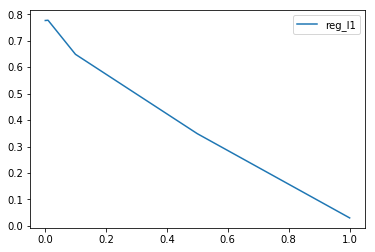

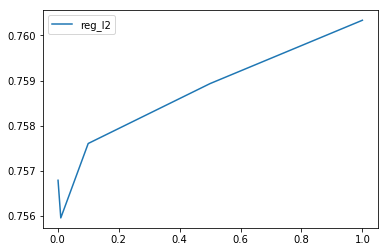

In [11]:
plt.plot(alphas, score_reg_l1, label = "reg_l1")
plt.legend()
plt.show()

plt.plot(alphas, score_reg_l2, label = "reg_l2")
plt.legend()
plt.show()

# Affichage des Poids
#### Sans Regularisation

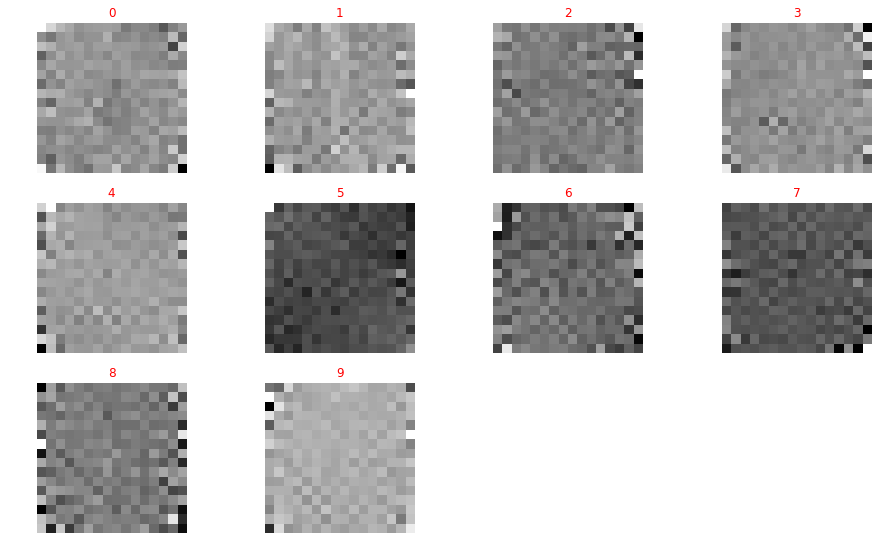

In [13]:
clf = LinearClassifier(penalty=None, use_tqdm=False)
clf.fit(x_train, y_train)
clf.plot_coefs((16, 16))

# Regularisation avec L2

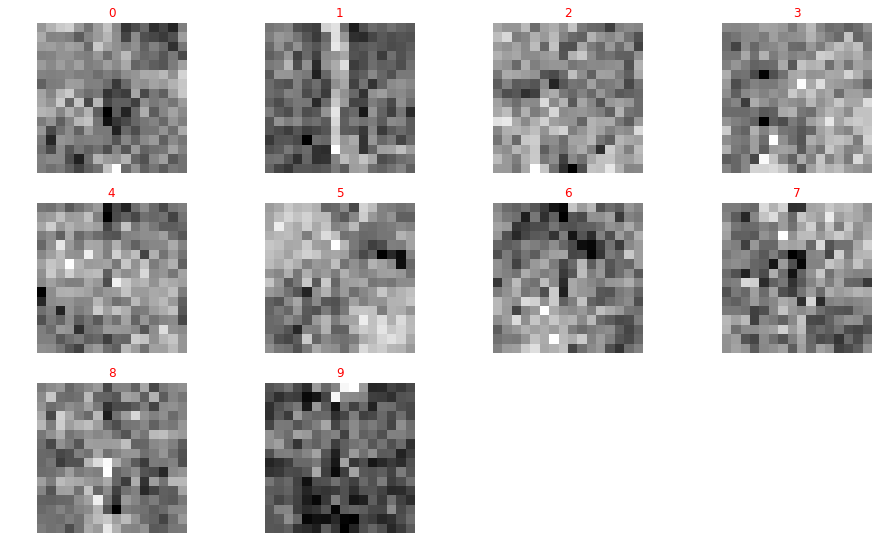

In [14]:
clf = LinearClassifier(penalty='l2', alpha=100, use_tqdm=False)
clf.fit(x_train, y_train)
clf.plot_coefs((16, 16))

# Regularisation avec L1

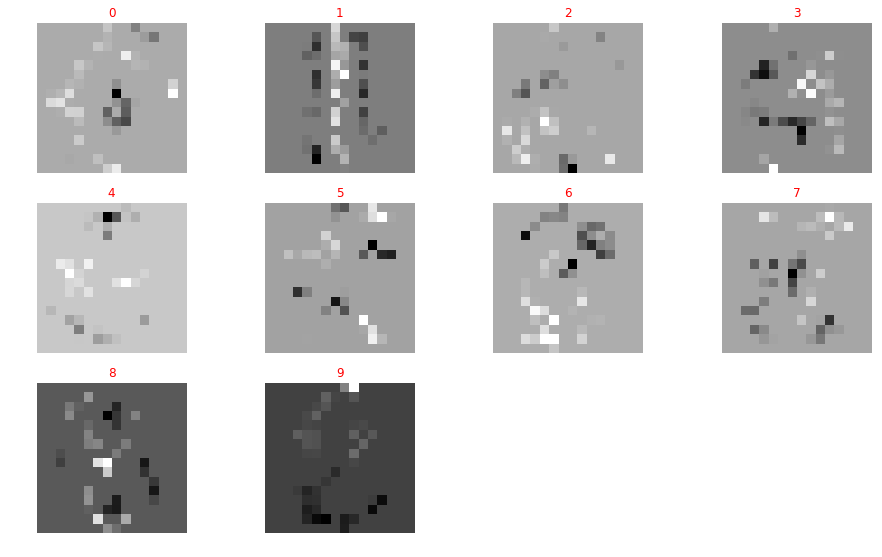

In [15]:
clf = LinearClassifier(penalty='l1', alpha=.05, use_tqdm=False)
clf.fit(x_train, y_train)
clf.plot_coefs((16, 16))

# LASSO et Inpainting 

In [93]:
H = 20
DEAD = -100

In [94]:
plt.ion()
IMG_FILE = "imgs/7.jpg"
img = tools.read_img(IMG_FILE)

patch = tools.get_patch(100, 100, img)
noisy = tools.noise_patch(patch)
imgnew, oldpatch = tools.remove_patch(220, 150, img)

(<matplotlib.image.AxesImage at 0x2972e5bd9e8>,
 <matplotlib.image.AxesImage at 0x2973aff8d30>)

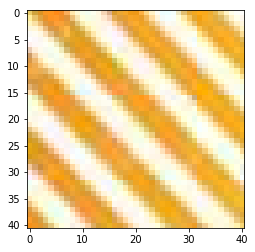

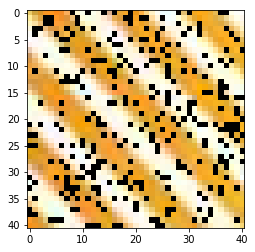

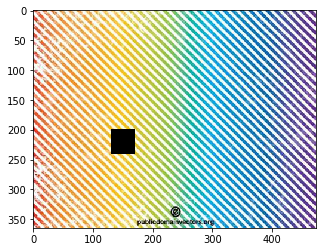

In [95]:
tools.show(patch), tools.show(noisy), tools.show(imgnew)

(1696, 117329)

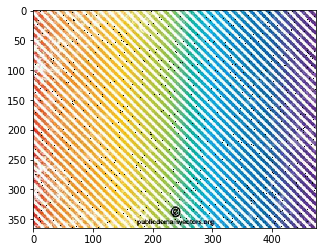

In [96]:
noisy_img = tools.noise_patch(img, prc=.01)
tools.show(noisy_img)
dict_patches, noisy_patches = tools.get_patches(noisy_img, H, 1)
len(dict_patches), len(noisy_patches)

# Inpainting Noise

In [98]:
class PatchesSelector:
    def __init__(self, alpha=.1):
        """Classe PatchesSelector permet de decomposer
        un patch en une combinaison restreintes en nombre
        de patch en foncton d'un dictionnaire visuel de patch.
        Comme nous avons pu voir precedamment le parametre alpha determine le nombre
        de patchs a selectionner par LASSO.
        
        alpha: cf. alpha 
        """
        self.alpha = alpha
        
    def fit(self, patches_dict, noisy_patch):
        self.noisy_patch = noisy_patch
        #un regresseur par channel...
        self.regressor_h = Lasso(alpha=self.alpha)
        self.regressor_s = Lasso(alpha=self.alpha)
        self.regressor_v = Lasso(alpha=self.alpha)
        #data
        (x_h, x_s, x_v), (y_h, y_s, y_v) = ([], [], []), ([], [], [])
        for i in range(patches_dict[0].shape[0]):
            for j in range(patches_dict[0].shape[1]):
                if not DEAD in noisy_patch[i, j]:
                    x_h.append(np.array(patches_dict)[:, i, j, 0].flatten())
                    x_s.append(np.array(patches_dict)[:, i, j, 1].flatten())
                    x_v.append(np.array(patches_dict)[:, i, j, 2].flatten())
                    y_h.append(noisy_patch[i, j, 0])
                    y_s.append(noisy_patch[i, j, 1])
                    y_v.append(noisy_patch[i, j, 2])
        #fit 
        self.regressor_h.fit(x_h, y_h)
        self.regressor_s.fit(x_s, y_s)
        self.regressor_v.fit(x_v, y_v)

    
    def reconstruct(self, patches_dict, noisy_patch=None):
        noisy_patch = self.noisy_patch if str(noisy_patch) == str(None) else noisy_patch
        noisy_patch = noisy_patch.copy()
        #reconstruction de l'image
        for i in range(noisy_patch.shape[0]):
            for j in range(noisy_patch.shape[1]):
                if DEAD in noisy_patch[i, j]:
                    h = self.regressor_h.predict([np.array(patches_dict)[:, i, j, 0]])[0]
                    s = self.regressor_s.predict([np.array(patches_dict)[:, i, j, 1]])[0]
                    v = self.regressor_v.predict([np.array(patches_dict)[:, i, j, 2]])[0]
                    noisy_patch[i, j, :] = np.array([h, s, v])
        return noisy_patch

100%|██████████| 3/3 [01:11<00:00, 23.93s/it]


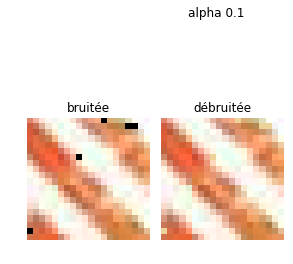

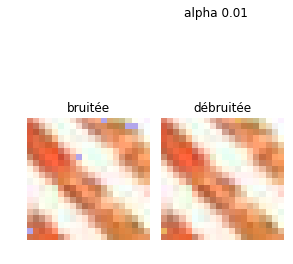

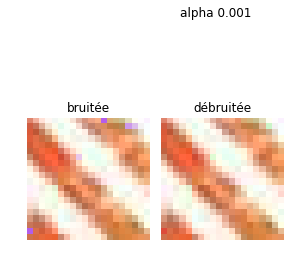

In [99]:
alphas = [ .1, .01, .001]

for alpha in tqdm(alphas):
    fig = plt.figure(figsize=(7, 5))
    gs = gridspec.GridSpec(1, 3) # img by row
    fig.suptitle("alpha {}".format(str(alpha)))
    
    ax = fig.add_subplot(gs[0, 0])
    ax.axis('off')
    ax.set_title("bruitée")
    ax.imshow(hsv_to_rgb(noisy_patches[1715] + .5))


    ps = PatchesSelector(alpha=alpha)
    ps.fit(dict_patches, noisy_patches[1715])
    ax = fig.add_subplot(gs[0, 1])
    ax.axis('off')
    ax.set_title("débruitée")
    ax.imshow(hsv_to_rgb(ps.reconstruct(dict_patches) + .5))

    gs.update(wspace=.1, hspace=.2)
    fig = plt.gcf()
    
    fig.show()

# Inpainting Patches

### Heuristiques
-----------------------

Nous proposons 3 heuristiques de remplissage:

# 1.Naive Way

In [20]:
def before_After(img_file,methode,iPatch, jPatch, wPatch, alpha = .01, patch_size = 20 ):
    """Affiche l'image deteriorée et l'image reconstruire a l'aide d'une methode donnée"""
    fig = plt.figure(figsize=(10,10))
    gs = gridspec.GridSpec(1, 2) 
    img = tools.read_img(img_file)
    
    dropped_img = tools.remove_patch(iPatch, jPatch, img, wPatch)[0] 
    
    ax = fig.add_subplot(gs[0,0])
    ax.imshow(hsv_to_rgb(dropped_img + .5))
    
    reconstructed_img = reconstruction(dropped_img, methode, alpha = alpha,patch_size=patch_size)
    
    ax = fig.add_subplot(gs[0,1])
    
    ax.imshow(hsv_to_rgb(reconstructed_img + .5))
    gs.update(wspace=.1, hspace=.2)
    fig = plt.gcf()
    fig.show()
    #return fig
def reconstruction(img, method, alpha=0.01, patch_size=20):
    return method().reconstruct(img, alpha=alpha, patch_size=patch_size)

In [21]:
class ReconstructionNaive:
    """"
    (int)*(int)*(int)=>(array(2D))
    img: image deteriorée
    alpha: parametre du LASSo
    patch_size: largeur du patch 
    limit_dico_size: limiter le nombre de patch pour l'entrainement  (pour des raison de rapidité)
    """
    def reconstruct(self, img, alpha=.001, patch_size=20, limit_dico_size=100):
        reconstructed_img = img.copy()
        dico, c = tools.get_patches(img, patch_size, 5)
        shuffle(dico)
        dico = dico[:limit_dico_size] #limit the number of patches allowed for learning to improve speed !!!
        for i in trange(len(reconstructed_img) - patch_size):
            for j in range(len(reconstructed_img[0]) - patch_size):
                if not reconstructed_img[i+patch_size, j+patch_size, 0] == DEAD:
                    continue
                lasso = PatchesSelector(alpha=alpha)
                lasso.fit(dico, reconstructed_img[i:i+patch_size, j:j+patch_size, :])
                reconstructed_img[i+patch_size, j+patch_size] = lasso.reconstruct(dico)[-1, -1]
        return reconstructed_img

## Test

100%|██████████| 345/345 [08:59<00:00,  1.57s/it]


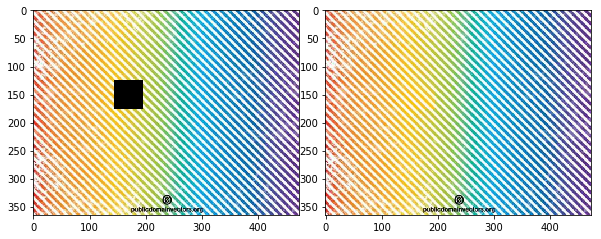

In [41]:
before_After("imgs/7.jpg",ReconstructionNaive,150,170,25,alpha=.01)

100%|██████████| 345/345 [08:34<00:00,  1.49s/it]


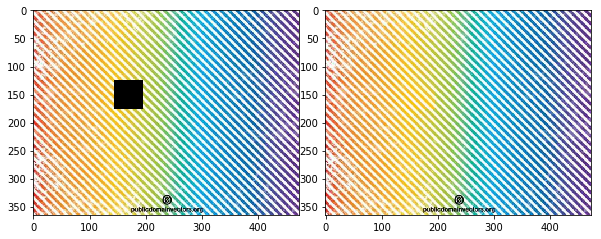

In [42]:
before_After("imgs/7.jpg",ReconstructionNaive,150,170,25,alpha=.001)

100%|██████████| 537/537 [19:53<00:00,  2.22s/it] 


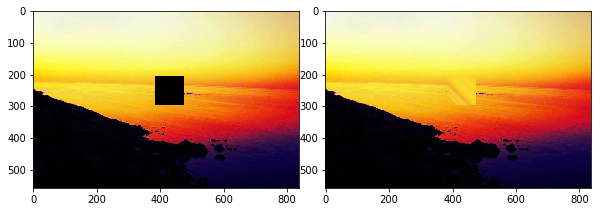

In [43]:
before_After("imgs/ile_des_pisans.png",ReconstructionNaive,250,430,45,alpha=.01)

100%|██████████| 537/537 [18:41<00:00,  2.09s/it] 


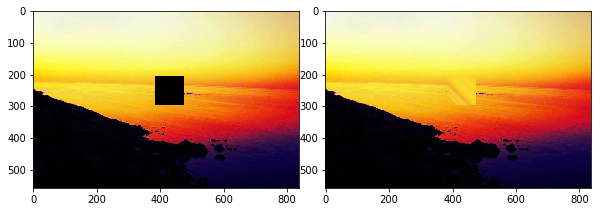

In [44]:
before_After("imgs/ile_des_pisans.png",ReconstructionNaive,250,430,45,alpha=.001)

In [80]:
IMG_FILE = "imgs/mongo.jpg"
iPatch = 125
jPatch = 185
wPatch = 10 

100%|██████████| 185/185 [02:01<00:00,  1.52it/s]


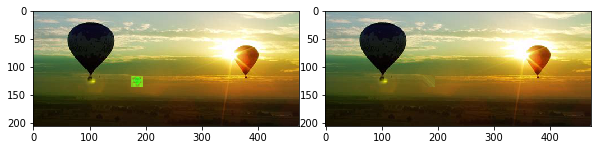

In [81]:
before_After(IMG_FILE,ReconstructionNaive,iPatch,jPatch,wPatch,alpha=.01)

100%|██████████| 375/375 [29:43<00:00,  4.76s/it]


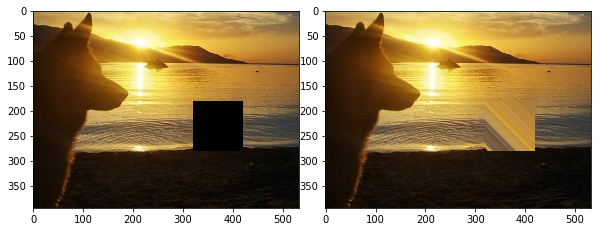

In [63]:
IMG_FILE = "imgs/chien.jpg"
iPatch = 230
jPatch = 370
wPatch = 50
before_After(IMG_FILE,ReconstructionNaive,iPatch,jPatch,wPatch,alpha=.01)

In [ ]:
class ReconstructionNaive2:
    """"
    (int)*(int)*(int)=>(array(2D))
    img: image deteriorée
    alpha: parametre du LASSo
    patch_size: largeur du patch 
    limit_dico_size: limiter le nombre de patch pour l'entrainement  (pour des raison de rapidité)
    """
    def reconstruct(self, img, alpha=.001, patch_size=20, limit_dico_size=100):
        reconstructed_img = img.copy()
        dico, c = tools.get_patches(img, patch_size, 5)
        shuffle(dico)
        dico = dico[:limit_dico_size] #limit the number of patches allowed for learning to improve speed !!!
        for j in trange(len(reconstructed_img[0]) - patch_size):
            for i in range(len(reconstructed_img) - patch_size):
                if not reconstructed_img[i+patch_size, j+patch_size, 0] == DEAD:
                    continue
                lasso = PatchesSelector(alpha=alpha)
                lasso.fit(dico, reconstructed_img[i:i+patch_size, j:j+patch_size, :])
                reconstructed_img[i+patch_size, j+patch_size] = lasso.reconstruct(dico)[-1, -1]
        return reconstructed_img

In [ ]:
IMG_FILE = "imgs/chien.jpg"
iPatch = 230
jPatch = 370
wPatch = 50
before_After(IMG_FILE,ReconstructionNaive2,iPatch,jPatch,wPatch,alpha=.01)

# Corner Way

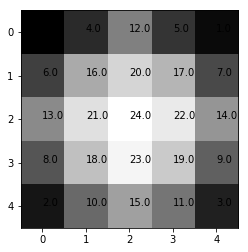

In [22]:
def get_nbgs(i, j):
    #obtenir les voisins 
    out = []
    for ii in range(i - 1, i + 2):
        for jj in range(j - 1, j + 2):
            if (ii, jj) != (i, j):
                out.append((ii, jj))
    return out

def order_by_corner(L):
    """    
    """
    L = L[:]
    ordered_list = []
    while L:
        ngbs = np.array(list(map(
                lambda c: len(list(filter(lambda c: c in L, get_nbgs(c[0], c[1])))),
                L
        )))
        t = []
        for i in np.where(ngbs == min(ngbs))[0]:
            ordered_list.append(L[i])
            t.append(L[i])
        for c in t:
            L.remove(c)
    return ordered_list

#Teste
L = [(i, j) for i in range(5) for j in range(5)]

M = np.zeros((5, 5))
ordered_list = order_by_corner(L)
for i in range(len(ordered_list)):
    M[ordered_list[i]] = i
M, ordered_list

tools.affichageHeuristique(M)

In [60]:
class ReconstructionCorner:
    
    def reconstruct(self, dropped_img, alpha=.001, patch_size=20, limit_dico_size=100):
        """La methode reconstruct, reconstruit l'image en remplissant le noisy patch en commencant par les coins de l'image
        En entrée:
        (array(2D))*(float)*(int)*(int)*(int)=>(array(2D))
        img: image deteriorée
        alpha: parametre du LASSo
        patch_size: largeur du patch 
        limit_dico_size: limiter le nombre de patch pour l'entrainement  (pour des raison de rapidité)
        """
        
        X, Y = np.where(dropped_img[:, :, 0] == DEAD)
        dico, c = tools.get_patches(dropped_img, patch_size, 5)
        shuffle(dico)
        
        dico = dico[:100]
        reconstructed_img = dropped_img.copy()
        coords_to_fill = list(zip(X, Y))
        coords_to_fill = order_by_corner(coords_to_fill)

        dico, c = tools.get_patches(dropped_img, patch_size, 5)
        shuffle(dico)
        dico = dico[:limit_dico_size]
        reconstructed_img = dropped_img.copy()
        
        for nb_pixel_reconstructed, (x, y) in tqdm(list(enumerate(coords_to_fill))):
            xx, yy = x, y
            if tools.hautDroite(reconstructed_img, x, y):
                x, y = x - patch_size, y - patch_size
                indx , indy = -1, 0
            elif tools.hautGauche(reconstructed_img, x, y):
                x, y = x - patch_size, y + patch_size
                indx , indy = -1, -1
            elif tools.basDroite(reconstructed_img, x, y):
                x, y = x + patch_size, y + patch_size
                indx , indy = 0, -1
            elif tools.basGauche(reconstructed_img, x, y):
                x, y = x + patch_size, y - patch_size
                indx, indy = 0, 0

            lasso = PatchesSelector(alpha=0.01)
            lasso.fit(dico, reconstructed_img[x:x+patch_size, y:y+patch_size])
            rp = lasso.reconstruct(dico, reconstructed_img[x:x+patch_size, y:y+patch_size])
            reconstructed_img[xx, yy] = rp[indx, indy]
        
        return reconstructed_img

# Test

In [30]:
IMG_FILE = "imgs/7.jpg"
iPatch = 150
jPatch = 170
wPatch = 25 

100%|██████████| 2601/2601 [09:43<00:00,  4.45it/s]


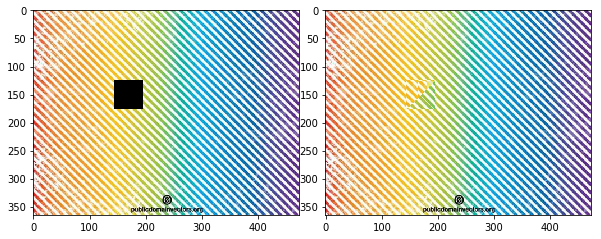

In [52]:
before_After(IMG_FILE,ReconstructionCorner,iPatch,jPatch,wPatch,alpha=.01)

100%|██████████| 2601/2601 [14:24<00:00,  3.01it/s]


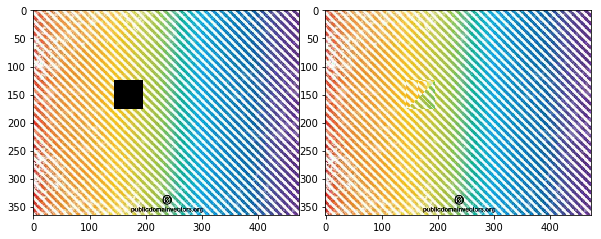

In [31]:
before_After(IMG_FILE,ReconstructionCorner,iPatch,jPatch,wPatch,alpha=.001)

0
1


100%|██████████| 10201/10201 [15:10:10<00:00,  5.35s/it] 


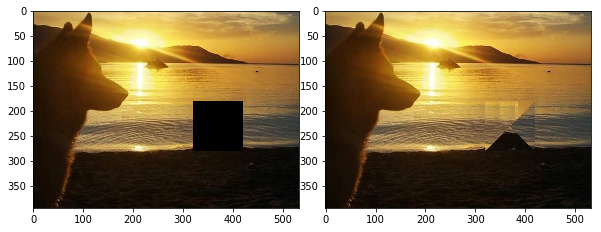

In [64]:
IMG_FILE = "imgs/chien.jpg"
iPatch = 230
jPatch = 370
wPatch = 50
before_After(IMG_FILE,ReconstructionCorner,iPatch,jPatch,wPatch,alpha=.01,patch_size=30)

In [100]:
IMG_FILE = "imgs/mongo.jpg"
iPatch = 125
jPatch = 185
wPatch = 10 

0
1


100%|██████████| 441/441 [02:12<00:00,  3.32it/s]


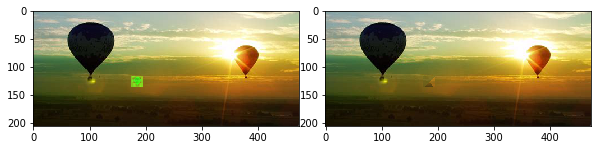

In [77]:
before_After(IMG_FILE,ReconstructionCorner,iPatch,jPatch,wPatch,alpha=.01)

0
1


100%|██████████| 441/441 [01:57<00:00,  3.74it/s]


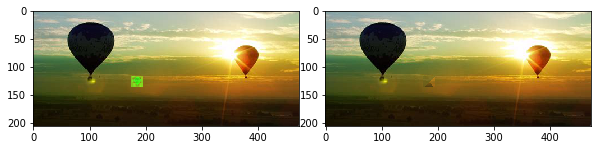

In [79]:
before_After(IMG_FILE,ReconstructionCorner,iPatch,jPatch,wPatch,alpha=.1)

In [32]:
IMG_FILE = "imgs/mer.jpg"
iPatch = 125
jPatch = 185
wPatch = 30 
img = img[200:,:-470]

100%|██████████| 3721/3721 [11:24<00:00,  5.44it/s]


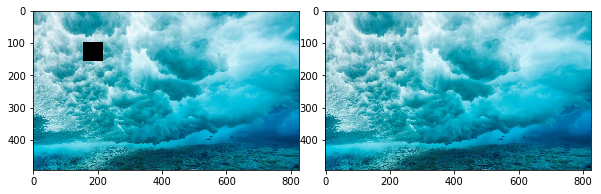

In [33]:
before_After(IMG_FILE,ReconstructionCorner,iPatch,jPatch,wPatch,alpha=.01)

100%|██████████| 441/441 [02:32<00:00,  2.89it/s]


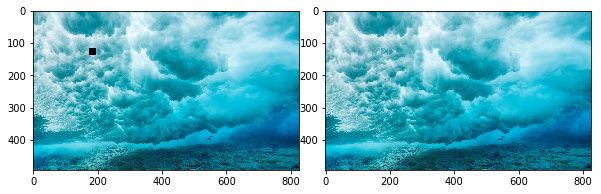

In [29]:
before_After(IMG_FILE,ReconstructionCorner,iPatch,jPatch,wPatch,alpha=.001)

# Spiral way

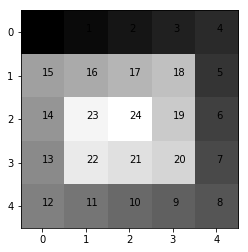

In [58]:
tools.affichageHeuristique(tools.spiral(5, 5))

In [70]:
class ReconstructionSpiral:
    
    def reconstruct(self, dropped_img, alpha=.001, patch_size=20, limit_dico_size=100):
        """La methode reconstruct, reconstruit l'image en remplissant le noisy patch en forme de spiral.
        En entrée:
        (array(2D))*(float)*(int)*(int)*(int)=>(array(2D))
        img: image deteriorée
        alpha: parametre du LASSo
        patch_size: largeur du patch 
        limit_dico_size: limiter le nombre de patch pour l'entrainement  (pour des raison de rapidité)
        """
        
        X, Y = np.where(dropped_img[:, :, 0] == DEAD)
        dico, c = tools.get_patches(dropped_img, patch_size, 5)
        shuffle(dico)
        dico = dico[:1500]
        reconstructed_img = dropped_img.copy()
        coords_to_fill = np.array(tools.spiral(
            len(dropped_img) - patch_size, 
            len(dropped_img[0]) - patch_size
        ))
        mat = []
        
        for i in range(len(coords_to_fill)):
            row = [] 
            for j in range(len(coords_to_fill[0])):
                row.append([i,j])
            mat.append(row)
        mat =  np.array(mat)
            
        coords = list( zip(coords_to_fill.flatten(),mat[:, :, 0].flatten(), mat[:, :, 1].flatten()))
        coords = sorted(coords)
        coords_to_fill = list(map(lambda c: (c[1],c[2]),  coords))
        dico, c = tools.get_patches(dropped_img, patch_size, 5)
        shuffle(dico)
        dico = dico[:limit_dico_size]
        reconstructed_img = dropped_img.copy()
        
        for nb_pixel_reconstructed, (x, y) in tqdm(list(enumerate(coords_to_fill))):
            xx, yy = x, y
            if DEAD in reconstructed_img[x:x + patch_size, y:y + patch_size] :
                if tools.hautDroite(reconstructed_img, x, y):
                    x, y = x - patch_size, y - patch_size,
                    indx , indy = -1, 0
                elif tools.hautGauche(reconstructed_img, x, y):
                    x, y = x - patch_size, y + patch_size,
                    indx , indy = -1, -1
                elif tools.basDroite(reconstructed_img, x, y):
                    x, y = x + patch_size, y + patch_size,
                    indx , indy = 0, -1
                elif tools.basGauche(reconstructed_img, x, y):
                    x, y = x + patch_size, y - patch_size,
                    indx, indy = 0, 0

                lasso = PatchesSelector(alpha=0.01)
                lasso.fit(dico, reconstructed_img[x:x + patch_size, y:y + patch_size])
                rp = lasso.reconstruct(dico, reconstructed_img[x:x + patch_size, y:y + patch_size])
                reconstructed_img[xx, yy] = rp[indx, indy]
        
        return reconstructed_img


In [78]:
IMG_FILE = "imgs/mongo.jpg"
iPatch = 125
jPatch = 185
wPatch = 10 

100%|██████████| 61122/61122 [03:56<00:00, 258.64it/s]  


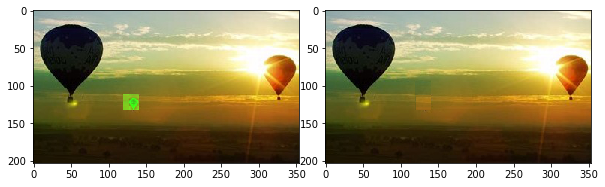

In [87]:
before_After(IMG_FILE,ReconstructionSpiral,iPatch,jPatch,wPatch,alpha=.01)


100%|██████████| 156630/156630 [27:51<00:00, 93.72it/s]   


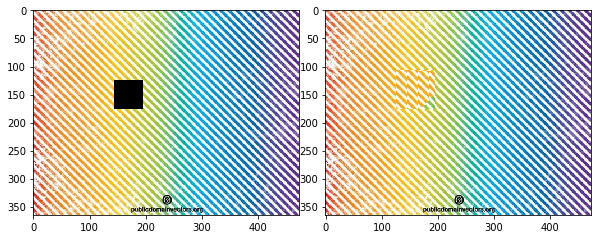

In [87]:
before_After("imgs/7.jpg",ReconstructionSpiral,150,170,25,alpha=.01)

In [88]:
IMG_FILE = "imgs/mer.jpg"
iPatch = 125
jPatch = 185
wPatch = 10 
img = img[200:,:-470]
before_After(IMG_FILE,ReconstructionS,iPatch,jPatch,wPatch,alpha=.1)

In [86]:
IMG_FILE = "imgs/mongo.jpg"
iPatch = 122
jPatch = 130
wPatch = 10 

100%|██████████| 56052/56052 [1:19:06<00:00, 11.81it/s] 


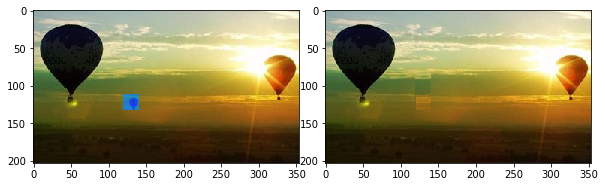

In [85]:
before_After(IMG_FILE,ReconstructionSpiral,iPatch,jPatch,wPatch,alpha=.01,patch_size=30)

Conclusion:
    L'efficacité de nos methodes de remplissage dependent fortement du contexe de l'image